In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import pandas as pd
import re
from underthesea import word_tokenize
from gensim import corpora, matutils
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count
import wordcloud
import seaborn as sns

In [2]:
DIR_PATH = os.path.dirname(os.path.realpath('/home/anhduc/Documents/data/text/'))
# load data
DATA_TRAIN_PATH = os.path.join(DIR_PATH, 'text/Train_Full/')
DATA_TEST_PATH = os.path.join(DIR_PATH, 'text/Test_Full/')
# stopword in vietnamese
STOP_WORDS = os.path.join(DIR_PATH, 'text/vietnamese-stopwords-dash.txt')
# data save link json file
SAVE_PATH_TRAIN = '/home/anhduc/result/train_set.json'
SAVE_PATH_TEST = '/home/anhduc/result/test_set.json'
# create dictionary
DICTIONARY_PATH_TRAIN = '/home/anhduc/result/dictionary_train.csv'
DICTIONARY_PATH_TEST = '/home/anhduc/result/dictionary_test.csv'
# model word2vec
MODEL_TRAIN = '/home/anhduc/result/model_train.model'
MODEL_TEST = '/home/anhduc/result/model_test.model'
# special character
SPECIAL_CHARACTER = '0123456789%@$.,=+-!;/()*"&^:#|\n\t\''

In [3]:
# Danh sach nhan
list_labels = os.listdir(path=DATA_TRAIN_PATH)
list_labels

['Phap luat',
 'Van hoa',
 'Suc khoe',
 'Vi tinh',
 'Khoa hoc',
 'Doi song',
 'Chinh tri Xa hoi',
 'The gioi',
 'The thao',
 'Kinh doanh']

In [4]:
# Load dữ liệu đầu vào
class load_data(object):
    def __init__(self, path, list_labels):
        self.path = path
        self.labels = list_labels
    # Lay noi dung file txt trong thu muc train de xu li
    def get_files(self):
        folders = [self.path + folder + '/' for folder in self.labels]
        contents = [] # danh sach nhan va duong dan
        labels = []
        for i in range(len(folders)):    
            f_text = os.listdir(folders[i])
            for f in f_text:
                link = folders[i] + '/' + f;
                file = open(link, encoding='utf16')
                contents.append(file.read())
                labels.append(i)
        return contents, labels
    def save_data(self, contents, labels, SAVE_PATH):
        self.contents = contents
        self.labels = labels
        self.SAVE_PATH = SAVE_PATH
        df = pd.DataFrame()
        df['label'] = self.labels
        df['content'] = self.contents
        df.to_json(self.SAVE_PATH)

In [5]:
# Xử lí dữ liệu
class handle_data(object):
    def __init__(self):
        self.contents = None
    # Tokenize and remove stopwords
    def tokenize(self, contents):
        self.contents = contents
        # tokenize, remove punctuation
        for i in range(len(self.contents)):
            self.contents[i] = re.sub(r'[^\w\s]','',
                                word_tokenize(self.contents[i], format='text').strip(SPECIAL_CHARACTER).lower()) 
        return self.contents
    def remove_stopwords(self, contents):
        self.contents = contents
        f = open(STOP_WORDS, encoding='utf8')
        sw = f.read()
        stop_words = sw.split('\n')
        for i in range(len(self.contents)):
            pre_text = []
            words = self.contents[i].split()
            for word in words: # remove stopwords
                if word not in stop_words:
                    pre_text.append(word)
            self.contents[i] = ' '.join(pre_text)
        return self.contents
    def creat_dict(self, contents, DICTIONARY_PATH, MODEL_PATH):
        self.backup = contents
        self.DICTIONARY_PATH = DICTIONARY_PATH
        self.MODEL_PATH = MODEL_PATH
        text = ' '.join(self.backup)
        splits_words = [w for w in text.split(' ')]
        dct = corpora.Dictionary([splits_words])
        dictionary = [w for w in dct.token2id]
        model = Word2Vec([dictionary], size=5, min_count=1, workers=cpu_count())
        model.wv.save(self.MODEL_PATH)
        df = pd.DataFrame()
        df['word'] = dictionary
        df['word'] = df['word'].fillna('none').values
        df.to_csv(self.DICTIONARY_PATH, encoding='utf8', index=False)
        return model, dictionary

# Xử lí dữ liệu

# Train set

- Đọc dữ liệu từ file

In [6]:
data_train = load_data(DATA_TRAIN_PATH, list_labels)
contents_train, labels_train = data_train.get_files()
handling_train = handle_data()

- Tokenize 
- Xóa các kí tự đặc biệt

In [7]:
new_contents_train = handling_train.tokenize(contents_train)

- Xóa stopwords

In [8]:
new_contents_train = handling_train.remove_stopwords(new_contents_train)

- Tạo từ điển

In [9]:
model_train, dictionary_train = handling_train.creat_dict(new_contents_train, DICTIONARY_PATH_TRAIN, MODEL_TRAIN)

- Lưu label và context

In [10]:
data_train.save_data(new_contents_train, labels_train, SAVE_PATH_TRAIN)

In [6]:
df_train = pd.read_json(SAVE_PATH_TRAIN)

# Thống kê số lượng text mỗi label

In [26]:
counts = []
for i in range(len(list_labels)):
    counts = counts + (list(df_train.label[df_train.label==i].value_counts()))
df_stats = pd.DataFrame(data={'Label': list_labels, 'NumOfContents': counts})
df_stats

,Label,NumOfContents
0,Phap luat,3868
1,Van hoa,3080
2,Suc khoe,3384
3,Vi tinh,2481
4,Khoa hoc,1820
5,Doi song,3159
6,Chinh tri Xa hoi,5219
7,The gioi,2898
8,The thao,5298
9,Kinh doanh,2552


Text(0.5, 0, 'Label')

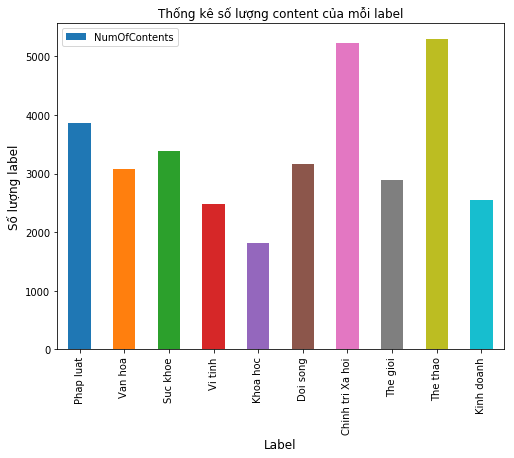

In [29]:
df_stats.plot(x='Label', y='NumOfContents', kind='bar', legend=True, grid=False, figsize=(8, 6))
plt.title("Thống kê số lượng content của mỗi label")
plt.ylabel('Số lượng label', fontsize=12)
plt.xlabel('Label', fontsize=12)

- Thống kê multi-label

In [68]:
counts = 0
size = df_train.content.size-1
for i in range(df_train.content.size):
    df_i = df_train.drop(index=df_train.label[i])
    if df_train.content[i] in df_i.content:
        print("Có multi-label")
        counts+=1
        break
    if (i==size):
        print("Không có multi-label")

Không có multi-label


In [40]:
df_train.content.isnull().sum()

0

- Thống kê độ dài trung bình của mỗi content trong data

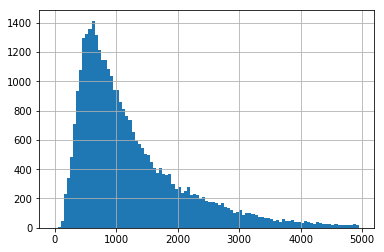

In [31]:
len_words = df_train.content.str.len()
len_words.hist(bins = np.arange(0,5000,50))

In [34]:
len_words.sum()/sum(counts)

1292.9946680885098

- Độ dài trung bình của một văn bản khoảng 1293 từ

- 200 từ xuất hiện nhiều nhất trong data

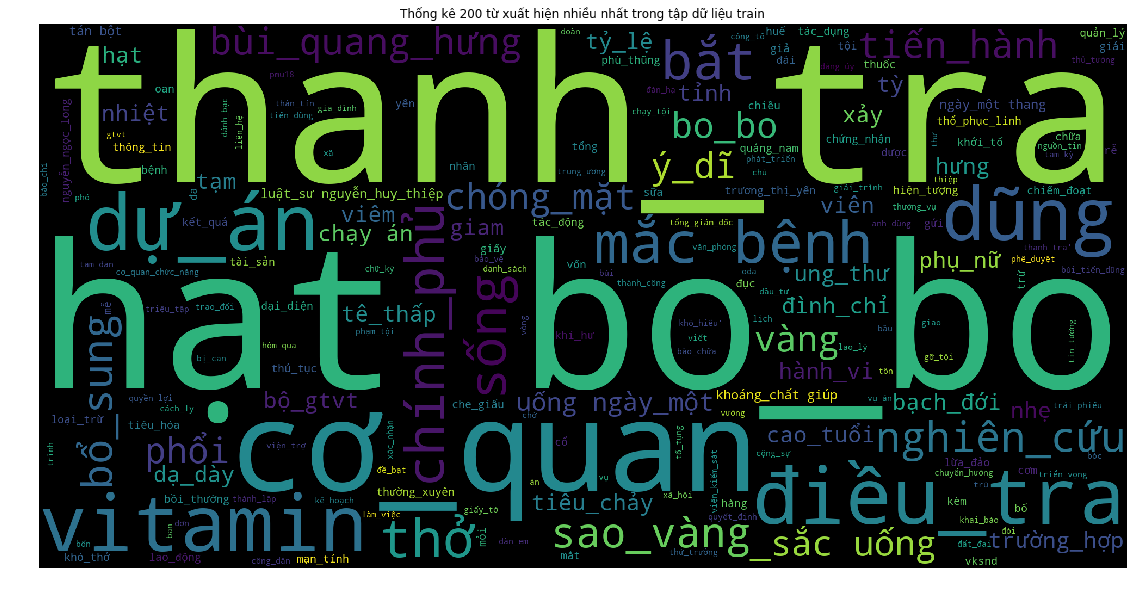

In [35]:
# Wordcloud of training set
cloud = np.array(df_train.content).flatten()
plt.figure(figsize=(20,10))
word_cloud = wordcloud.WordCloud(
    max_words=200,background_color ="black",
    width=2000,height=1000,mode="RGB"
).generate(str(cloud))
plt.title("Thống kê 200 từ xuất hiện nhiều nhất trong tập dữ liệu train")
plt.axis("off")
plt.imshow(word_cloud)

# Test set

In [70]:
data_test = load_data(DATA_TEST_PATH, list_labels)
contents_test, labels_test = data_test.get_files()
handling_test = handle_data()

In [71]:
new_contents_test = handling_test.tokenize(contents_test)

In [72]:
new_contents_test = handling_test.remove_stopwords(new_contents_test)

In [73]:
model_test, dictionary_test = handling_test.creat_dict(new_contents_test, DICTIONARY_PATH_TEST, MODEL_TEST)

In [74]:
data_test.save_data(new_contents_test, labels_test, SAVE_PATH_TEST)

In [75]:
df_test = pd.read_json(SAVE_PATH_TEST)

In [76]:
counts = []
for i in range(len(list_labels)):
    counts = counts + (list(df_test.label[df_test.label==i].value_counts()))
df_stats = pd.DataFrame(data={'Label': list_labels, 'NumOfContents': counts})
df_stats

,Label,NumOfContents
0,Phap luat,3788
1,Van hoa,6250
2,Suc khoe,5417
3,Vi tinh,4560
4,Khoa hoc,2096
5,Doi song,2036
6,Chinh tri Xa hoi,7567
7,The gioi,6716
8,The thao,6667
9,Kinh doanh,5276


Text(0.5, 0, 'Label')

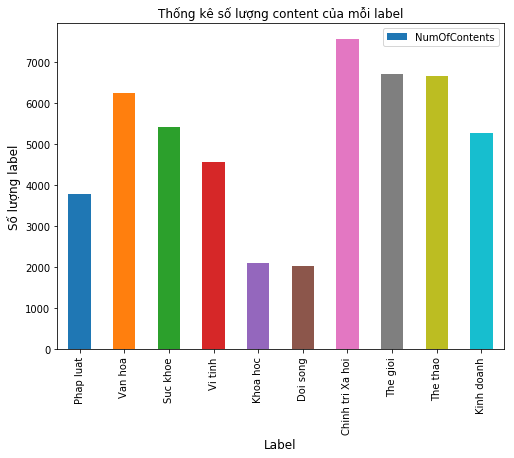

In [77]:
df_stats.plot(x='Label', y='NumOfContents', kind='bar', legend=True, grid=False, figsize=(8, 6))
plt.title("Thống kê số lượng content của mỗi label")
plt.ylabel('Số lượng label', fontsize=12)
plt.xlabel('Label', fontsize=12)

In [79]:
counts = 0
size = df_test.content.size-1
for i in range(df_test.content.size):
    df_i = df_test.drop(index=df_test.label[i])
    if df_test.content[i] in df_i.content:
        print("Có multi-label")
        counts+=1
        break
    if (i==size):
        print("Không có multi-label")

Không có multi-label


In [80]:
df_test.content.isnull().sum()

0

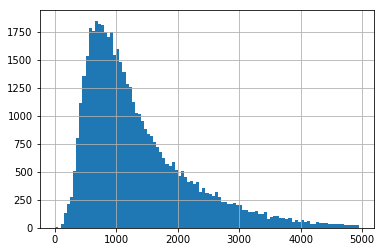

In [81]:
len_words = df_test.content.str.len()
len_words.hist(bins = np.arange(0,5000,50))

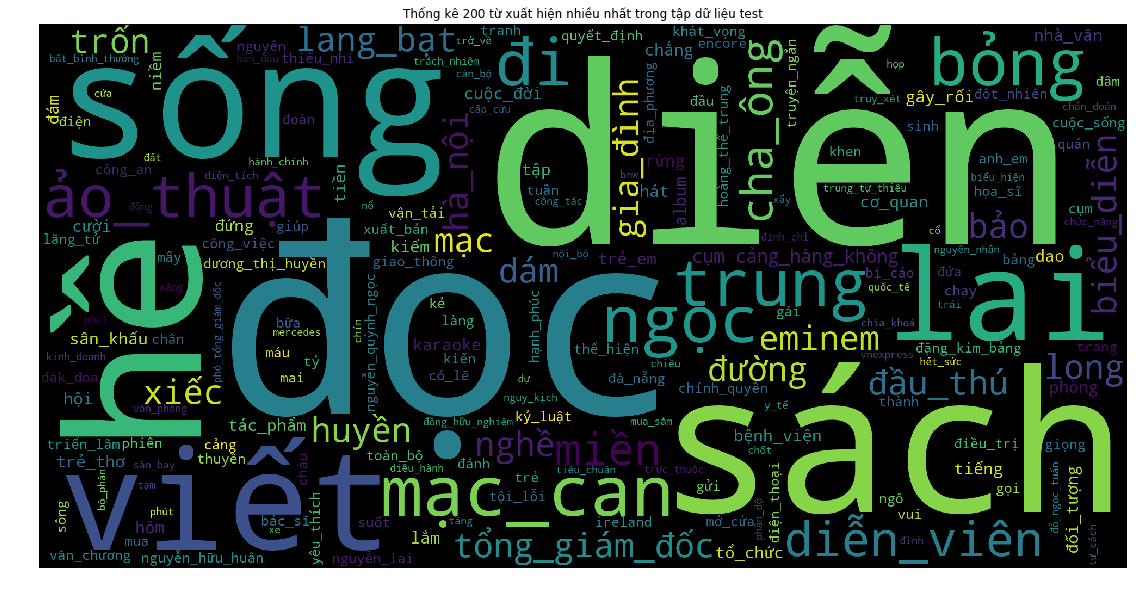

In [82]:
# Wordcloud of training set
cloud = np.array(df_test.content).flatten()
plt.figure(figsize=(20,10))
word_cloud = wordcloud.WordCloud(
    max_words=200,background_color ="black",
    width=2000,height=1000,mode="RGB"
).generate(str(cloud))
plt.title("Thống kê 200 từ xuất hiện nhiều nhất trong tập dữ liệu test")
plt.axis("off")
plt.imshow(word_cloud)